In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
# rcParams['figure.figsize'] = 5, 4
# rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

# select device: change to 'cpu' if there's no GPU device
device = 'gpu'

if device == 'gpu':
    torch.cuda.set_device(0)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

if device == 'cpu':
    torch.set_default_tensor_type(torch.DoubleTensor)

In [26]:
class ScaleAndShift(nn.Module):
    def __init__(self, input_features, K=1):
        super(ScaleAndShift, self).__init__()
        self.input_features = input_features # Dimension of parameter space p
        self.K = K # Number of mixtures

        # nn.Parameter is a special kind of Tensor, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters require gradients by default.
        
        self.logscale = nn.Parameter(torch.Tensor(input_features,K)) # Matrix dim=[p,K]
        self.shift = nn.Parameter(torch.Tensor(input_features,K)) # Matrix dim=[p,K]

        self.logscale.data.uniform_(-1, 1)
        self.shift.data.uniform_(-1, 1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        
        # input dimension dim=[batch_no,p]
        batch_no = input.shape[0] # Number of batch simulation as the first dimension
        p = self.input_features # Dimension of parameter space
        
        K = self.K # Number of mixtures
        
#         self.logscale = self.scale_raw  # torch.tanh(self.scale_raw)
        self.scale = torch.exp(self.logscale)
        
        x_rep = input.reshape([batch_no,1,p]).repeat(1,K,1)  # Tensor of dimension [batch_no,K,p]
        w_rep = self.scale.T.reshape([1,K,p]).repeat(batch_no,1,1) # Tensor of dimension [batch_no,K,p]
        b_rep = self.shift.T.reshape([1,K,p]).repeat(batch_no,1,1) # Tensor of dimension [batch_no,K,p]

        return x_rep*w_rep+b_rep # Tensor of dimension [batch_no,K,p]. Element-wise multiplication between x_rep and w_rep. 

    def print_param(self):
        # (Optional)Set the extra information about this module. You can test
        # it by printing an object of this class.
        scale = torch.exp(self.logscale)
        return 'scale={}, shift={}'.format(
            scale, self.shift
        )

In [6]:
class KCat(nn.Module):
    def __init__(self, input_features, K=1):
        super(KCat, self).__init__()
        self.input_features = input_features # Dimension of parameter space p
        self.K = K # Number of mixtures
        
        self.w = nn.Parameter(torch.Tensor(input_features,K)) # Tensor of dimension [p,K]
        self.b0 = nn.Parameter(torch.Tensor(K)) # Tensor of dimension [K]

        self.w.data.uniform_(-1, 1)
        self.b0.data.uniform_(-1, 1)

        
    def forward(self, input,dim=1):
        # input dimension dim=[p]
        # b leaves in the log-space
        b = self.b0 - torch.logsumexp(self.b0,0,keepdim=True) #exp(b)=exp(b0)/(sum exp(b0)) so b is the log of the normalized exp(b0) vector, i.e. sum(exp(b)) = 1
        
        xw_b = input@self.w+ b # input dim=[p], self.w dim=[p,K], b dim=[K];   @: matrix vector multiplication in python
        return xw_b - torch.logsumexp(xw_b,dim=dim,keepdim=True)

In [7]:
batch_no = 1000
p = 2  # Dimension of the parameter space
K = 100  # Number of mixture components

In [8]:
scale_shift = ScaleAndShift(p,K)
kcat = KCat(p,K)

In [27]:
scale_shift.print_param()

'scale=tensor([[1.1081e+00, 1.1445e+00, 4.1506e+00, 6.8180e+01, 3.6774e-01, 1.7465e+00,\n         8.1544e-01, 7.7898e-01, 1.9388e+00, 2.5957e+02, 7.2629e+00, 4.2278e+00,\n         1.1527e+00, 1.5273e+00, 1.8817e+00, 8.7285e-01, 4.9638e-01, 1.0249e+00,\n         1.5874e+00, 4.9808e-01, 1.2034e+01, 3.8109e-01, 1.7885e+00, 2.4284e+00,\n         1.2377e+01, 5.6586e-01, 2.5313e+00, 1.3773e+00, 5.2750e-01, 8.8864e+00,\n         5.7872e+00, 3.7123e+00, 1.2408e+00, 7.1370e-01, 2.7733e+00, 4.8082e+00,\n         3.4659e+00, 1.8624e+00, 2.8356e+00, 1.5239e+00, 2.0943e+00, 6.0916e+00,\n         3.1084e+00, 9.6384e-01, 3.4286e-01, 7.3255e+00, 1.0816e+00, 8.9727e+00,\n         1.9748e+00, 1.8780e+00, 9.7893e-01, 1.9922e+00, 4.2822e+00, 8.6835e-01,\n         2.1717e+00, 1.8762e+00, 1.0108e+00, 5.1210e+00, 9.3010e-01, 8.9507e-01,\n         3.8818e+00, 5.6860e+00, 5.6046e-01, 1.1128e+00, 1.8196e+00, 1.5725e+00,\n         1.3986e+00, 1.1936e+00, 9.1972e+00, 3.2851e+00, 3.5521e+00, 6.4449e+00,\n         

In [45]:
# scale_shift.logscale is a matrix of dimension [p,K]
scale_shift.logscale.data.size()


torch.Size([2, 100])

In [85]:
# scale_shift.shift is a matrix of dimension [p,K]
print("shift type: ",type(scale_shift.shift))
print("shift size: ",scale_shift.shift.data.size())
print("shift first element in first dimension: ",scale_shift.shift[0][0:5])
print("shift first element in second dimension: ",scale_shift.shift[1][0:5])
print("shift :",scale_shift.shift[:,:5])
print("Shift transpose size",scale_shift.shift.T.size())# T is for transpose
print("shift transpose first element in first dimension: ",scale_shift.shift.T[0][0:2])
print("shift transpose first element in second dimension: ",scale_shift.shift.T[1][0:2])
print("shift transpose: ",scale_shift.shift.T[:5,:])

shift type:  <class 'torch.nn.parameter.Parameter'>
shift size:  torch.Size([2, 100])
shift first element in first dimension:  tensor([ 1.8180, -0.7378,  1.1153, -1.0171,  2.0519], grad_fn=<SliceBackward>)
shift first element in second dimension:  tensor([-0.0962,  0.4050, -0.2291,  1.6601, -0.6583], grad_fn=<SliceBackward>)
shift : tensor([[ 1.8180, -0.7378,  1.1153, -1.0171,  2.0519],
        [-0.0962,  0.4050, -0.2291,  1.6601, -0.6583]],
       grad_fn=<SliceBackward>)
Shift transpose size torch.Size([100, 2])
shift transpose first element in first dimension:  tensor([ 1.8180, -0.0962], grad_fn=<SliceBackward>)
shift transpose first element in second dimension:  tensor([-0.7378,  0.4050], grad_fn=<SliceBackward>)
shift transpose:  tensor([[ 1.8180, -0.0962],
        [-0.7378,  0.4050],
        [ 1.1153, -0.2291],
        [-1.0171,  1.6601],
        [ 2.0519, -0.6583]], grad_fn=<SliceBackward>)


In [68]:
# Using torch tensor
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(x)
print(x[0])
print(x[0][2])

tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([1, 2, 3])
tensor(3)


In [98]:
batch_no = 6
print("shift T:",scale_shift.shift.T[:5,:])
print("shift transpose size: ",scale_shift.shift.T.size())
print("shift transpose after reshape (notice one more bracket):",scale_shift.shift.T.reshape([1,K,p])[:,:5,:])
print("shift transpose after reshape dimension: ",scale_shift.shift.T.reshape([1,K,p]).size())
print("shift transpose after reshape (notice one more bracket):",scale_shift.shift.T.reshape([1,K,p])[:,:5,:])
print("shift transpose after reshape and repeat: ",scale_shift.shift.T.reshape([1,K,p]).repeat(batch_no,1,1)[:3,:5,:])
print("shift transpose after reshape and repeat dimension: ",scale_shift.shift.T.reshape([1,K,p]).repeat(batch_no,1,1).size())
# x_rep*w_rep+b_rep # Tensor of dimension [batch_no,K,p]. Element-wise multiplication between x_rep and w_rep. 


shift T: tensor([[ 1.8180, -0.0962],
        [-0.7378,  0.4050],
        [ 1.1153, -0.2291],
        [-1.0171,  1.6601],
        [ 2.0519, -0.6583]], grad_fn=<SliceBackward>)
shift transpose size:  torch.Size([100, 2])
shift transpose after reshape (notice one more bracket): tensor([[[ 1.8180, -0.0962],
         [-0.7378,  0.4050],
         [ 1.1153, -0.2291],
         [-1.0171,  1.6601],
         [ 2.0519, -0.6583]]], grad_fn=<SliceBackward>)
shift transpose after reshape dimension:  torch.Size([1, 100, 2])
shift transpose after reshape (notice one more bracket): tensor([[[ 1.8180, -0.0962],
         [-0.7378,  0.4050],
         [ 1.1153, -0.2291],
         [-1.0171,  1.6601],
         [ 2.0519, -0.6583]]], grad_fn=<SliceBackward>)
shift transpose after reshape and repeat:  tensor([[[ 1.8180, -0.0962],
         [-0.7378,  0.4050],
         [ 1.1153, -0.2291],
         [-1.0171,  1.6601],
         [ 2.0519, -0.6583]],

        [[ 1.8180, -0.0962],
         [-0.7378,  0.4050],
         

In [50]:
scale_shift.shift.T.size()

torch.Size([100, 2])

In [101]:
class Loglik(nn.Module):
    def __init__(self):
        super(Loglik, self).__init__()
        
        # Parameter of the mixture
        # theta |y ~ + 0.5 N([5 ; 2],[1 0.5; 0.5 1]) + 0.5 N([-3 ; -1],[1*s1^2 -0.9*s1 ; -0.9*s1 1]) 
        s1 = 1
        
        # Covariance matrices of the 2 mixture components
        sigma0 = 1
        Sigma1 = torch.tensor(np.reshape(np.array([1,0.5,0.5,1], np.float64),[2,2])) * sigma0**2
        Sigma2 = torch.tensor(np.reshape(np.array([1*s1**2,-0.9*s1,-0.9*s1,1], np.float64),[2,2])) * sigma0**2

        self.Omega1 = (Sigma1).inverse()
        self.Omega2 = (Sigma2).inverse()

        # Mode of the gaussian distribution
        self.Mu1 = torch.tensor(np.matrix([5,2]))
        self.Mu2 = torch.tensor(np.matrix([-3,-1]))

        # log determinant of the covariance matrices
        self.logSigma1 = torch.logdet(Sigma1)
        self.logSigma2 = torch.logdet(Sigma2)
              
    def f(self, theta):
        # Calculate the likelihood of a theta for the mixture posterior
        # logLik of one Gaussian N(mu,Sigma) with dim(mu)= n:       logLik = -0.5*n*log(2*pi) - log(det(Sigma))/2.0 - (x-mu)^T*\Sigma^(-1)*(x-mu)/2.0
        # Here n = 2:  logLik = -log(2*pi) - log(det(Sigma))/2.0 - (x-mu)^T*\Sigma^(-1)*(x-mu)/2.0
        #              logLik = -log(2*pi) - log(det(Sigma))/2.0 - quad/2.0  with quad = (x-mu)^T*\Sigma^(-1)*(x-mu)
        #
        # logLik of the mixture of two gaussians: (See https://stephens999.github.io/fiveMinuteStats/intro_to_em.html)
        # Lik = 0.5*N(M1,Sigma1) + 0.5 *N(Mu2,Sigma2)
        # logLik = log( sum_{k=1..K} [0.5 * N(M1,Sigma1) ; 0.5 * N(Mu2,Sigma2)])  with K=2
        #        = log(0.5) + log( sum_{k=1..K} [N(M1,Sigma1) ; N(Mu2,Sigma2)])
        #        = log(0.5) + log( sum_{k=1..K} exp [ - quad1/2.0 - logdet(Sigma1)/2.0 -log(2*pi) ; - quad2/2.0 - logdet(Sigma2)/2.0 -log(2*pi)])
        #        = log(0.5) - log(2*pi) + log( sum_{k=1..K} exp [ - quad1/2.0 - logdet(Sigma1)/2.0  ; - quad2/2.0 - logdet(Sigma2)/2.0 ])
        Mu1 = self.Mu1
        Mu2 = self.Mu2
        Omega1 = self.Omega1
        Omega2 = self.Omega2
        logSigma1 = self.logSigma1
        logSigma2 = self.logSigma2

        diff1 = (theta-Mu1) # theta dim = 1,2
        quad1 = torch.diagonal( diff1@Omega1@torch.transpose(diff1,1,2),dim1=1,dim2=2) # matrix multiplication (theta-Mu1) x Omega1 x (theta-Mu1)^T

        diff2 = (theta-Mu2)
        quad2 = torch.diagonal( diff2@Omega2@torch.transpose(diff2,1,2),dim1=1,dim2=2)

        comp_loglik1 =  - quad1/2.0 - logSigma1/2.0 
        comp_loglik2 = - quad2/2.0 - logSigma2/2.0 

        loglik = torch.logsumexp(torch.stack([comp_loglik1,comp_loglik2]),dim=0) + np.log(0.5) -np.log(2*np.pi) # sum in logsumexp over the number of mixtures
        return  loglik

compLoglik = Loglik()

In [100]:
print("Mu1: ",torch.tensor(np.matrix([5,2])))
print("Mu1 dim:",torch.tensor(np.matrix([5,2])).size())

Mu1:  tensor([[5, 2]])
Mu1 dim: torch.Size([1, 2])


In [12]:
para_list=list()
para_list +=  list(scale_shift.parameters()) #logscale and shift parameter to calculate the exp(log_scale)*input+shift
para_list +=  list(kcat.parameters())

In [13]:
len(para_list)

4

In [14]:
scale_shift.parameters()

<generator object Module.parameters at 0x7f518ac157d8>

In [15]:
import copy

best_loss = np.inf

Optimize to learn the random transport, as a mixture of K maps

In [16]:

def dirichlet_prior(logb):
    alpha= 0.5
    return (alpha/K-1) * log_b.sum()

In [17]:
optimizer = torch.optim.Adam([p for p in para_list if p.requires_grad==True], lr=1e-1)

In [18]:
for t in range(3000):
    
    r = 10.
    beta = torch.rand([batch_no,p])* r - r/2.

    theta = scale_shift(beta)
        
    mix_weight = torch.diagonal(kcat(theta,dim=2),0,1,2) #kcat(beta)

    logjacobian = scale_shift.logscale.sum(0)

    target_log_density = compLoglik.f(theta) + logjacobian

    weighted_target = target_log_density + mix_weight

    total = torch.logsumexp(weighted_target,dim=1)
    
    #regularize b:    
    log_b = kcat.b0 - torch.logsumexp(kcat.b0,0, keepdim=True)
    w = kcat.w    

    loss =  - total.mean()
    total_loss =  loss  + dirichlet_prior(log_b)   
    
    if t%100==0:
        print(t, np.log(1.0/100.0) - total.mean())
          

    if loss.item()< best_loss:
        param_bak = copy.deepcopy( [scale_shift.state_dict(), kcat.state_dict()])
        best_loss = loss.item()

        
    if np.isnan(loss.item()):
        scale_shift = ScaleAndShift(p,K)
        kcat = KCat(p,K)
        scale_shift.load_state_dict(param_bak[0])
        kcat.load_state_dict(param_bak[1])
        kcat.eval()
        scale_shift.eval()
#         optimizer.zero_grad()
        pass
          
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    total_loss.backward(retain_graph=True)

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 tensor(3.0235, grad_fn=<RsubBackward1>)
100 tensor(0.1510, grad_fn=<RsubBackward1>)
200 tensor(0.1090, grad_fn=<RsubBackward1>)
300 tensor(0.1177, grad_fn=<RsubBackward1>)
400 tensor(0.1029, grad_fn=<RsubBackward1>)
500 tensor(0.1217, grad_fn=<RsubBackward1>)
600 tensor(0.0856, grad_fn=<RsubBackward1>)
700 tensor(0.0900, grad_fn=<RsubBackward1>)
800 tensor(0.0828, grad_fn=<RsubBackward1>)
900 tensor(0.0831, grad_fn=<RsubBackward1>)
1000 tensor(0.0957, grad_fn=<RsubBackward1>)
1100 tensor(0.1389, grad_fn=<RsubBackward1>)
1200 tensor(0.0850, grad_fn=<RsubBackward1>)
1300 tensor(0.0969, grad_fn=<RsubBackward1>)
1400 tensor(0.1066, grad_fn=<RsubBackward1>)
1500 tensor(0.0876, grad_fn=<RsubBackward1>)
1600 tensor(0.0854, grad_fn=<RsubBackward1>)
1700 tensor(0.1092, grad_fn=<RsubBackward1>)
1800 tensor(0.0865, grad_fn=<RsubBackward1>)
1900 tensor(0.0960, grad_fn=<RsubBackward1>)
2000 tensor(0.0989, grad_fn=<RsubBackward1>)
2100 tensor(0.0892, grad_fn=<RsubBackward1>)
2200 tensor(0.0746, gr

In [19]:
def getNp(x):
    return x.detach().cpu().numpy()

In [20]:
g= getNp( np.log(1.0/100.0) - total[:1000])


In [21]:
g.mean()

0.09355228198882491

In [22]:
beta

tensor([[-1.1898, -2.7345],
        [ 1.2948, -3.9808],
        [ 0.3646, -4.3066],
        ...,
        [-0.7320, -2.8799],
        [-3.6863,  0.9330],
        [ 1.5573, -0.5492]])

In [23]:
post_sample_beta=list()
post_sample_theta=list()
post_sample_choice =list()
post_sample_map_choice =list()

for i in range(50):
    theta = scale_shift(beta)
    mix_weight = torch.diagonal(kcat(theta,dim=2),0,1,2) #kcat(beta)
#     mix_weight = torch.stack([kcat(theta[:,k,:])[:,k] for k in range(K)],dim=1)
    logjacobian = scale_shift.logscale.sum(0)

    target_log_density = compLoglik.f(theta) + logjacobian

    weighted_target = target_log_density + mix_weight
    theta_np = getNp(theta)

    weight_np =getNp(weighted_target)

    pick = np.argmax(weight_np+ np.random.gumbel(size= [batch_no,K]),axis=1)
    map_pick = np.argmax(weight_np,axis=1)

    post_sample_beta.append(getNp(beta))
    post_sample_theta.append(np.array([theta_np[i,pick[i],:] for i in range(batch_no)]))
    post_sample_choice.append(pick)
    post_sample_map_choice.append(map_pick)

beta_sample = np.vstack(post_sample_beta)
theta_sample = np.vstack(post_sample_theta)
post_sample_choice = np.hstack(post_sample_choice)
post_sample_map_choice = np.hstack(post_sample_map_choice)

In [24]:
rcParams['figure.dpi'] = 300

(-10.0, 10.0)

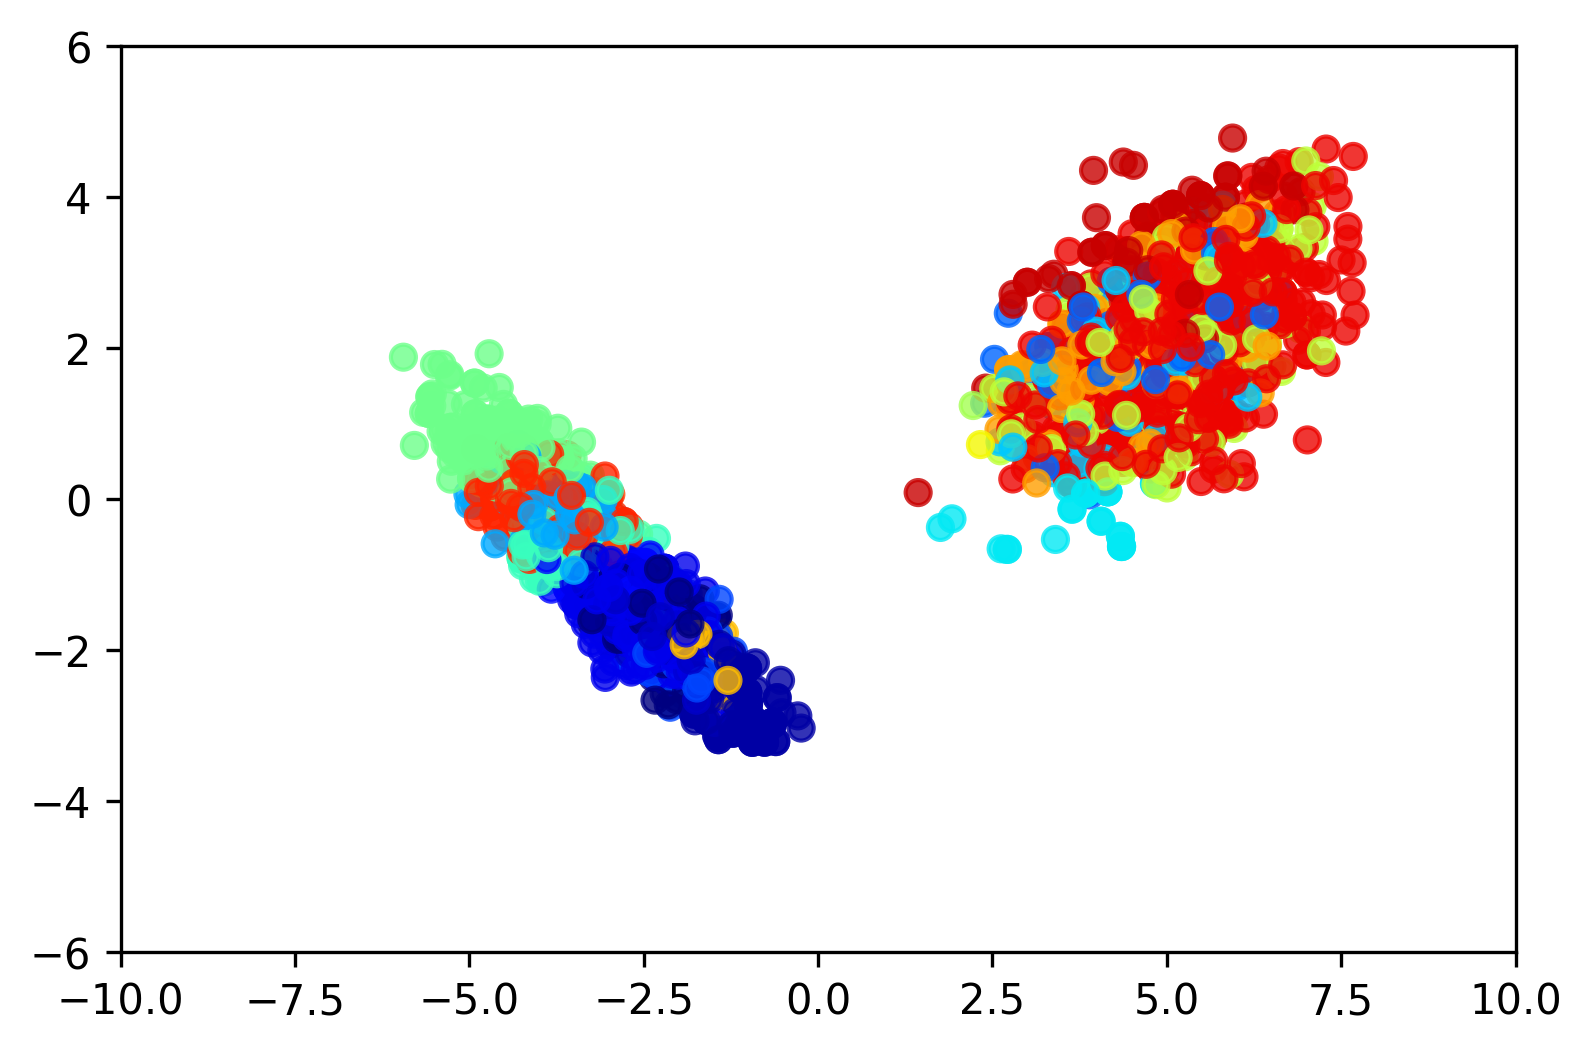

In [25]:
col = post_sample_choice
_, col1 = np.unique(col, return_inverse=True)


plot_n = 3000
plt.figure(figsize=[6, 4])
plt.scatter(theta_sample[:plot_n,0],theta_sample[:plot_n,1],c=col1[:plot_n], alpha=.8,cmap='jet_r')
plt.ylim(-6,6)
plt.xlim(-10,10)